In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import os
import joblib  # Untuk menyimpan model
from wordcloud import WordCloud

# Machine Learning Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

# Deep Learning TensorFlow/Keras
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D

# Download resource bahasa untuk NLTK
nltk.download('stopwords')
from nltk.corpus import stopwords

# Styling
sns.set(style='whitegrid')
print("Library berhasil di-load!")

Library berhasil di-load!


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
#@title Memuat Dataset
print("--- Memuat Data ---")
try:
    df = pd.read_json('classified_abstracts.json')
    print(f"Data dimuat. Total baris: {df.shape[0]}, Total kolom: {df.shape[1]}")
    print("\nSample Data:")
    print(df[['Abstract', 'Label']].head())
except ValueError:
    print("File 'classified_abstracts.json' tidak ditemukan. Harap upload file terlebih dahulu.")

--- Memuat Data ---
Data dimuat. Total baris: 1138, Total kolom: 3

Sample Data:
                                            Abstract  Label
0  Forward-looking forecasting of the inflation r...      1
1  Our study examined the disaggregation of infla...      1
2  This paper develops a dynamic factor model tha...      0
3  In this paper, I use a simple SIR Macro model ...      0
4  BackgroundGame theory is useful for identifyin...      0


--- Menampilkan Visualisasi ---


/tmp/ipython-input-2291693837.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Label', data=df, palette='viridis')


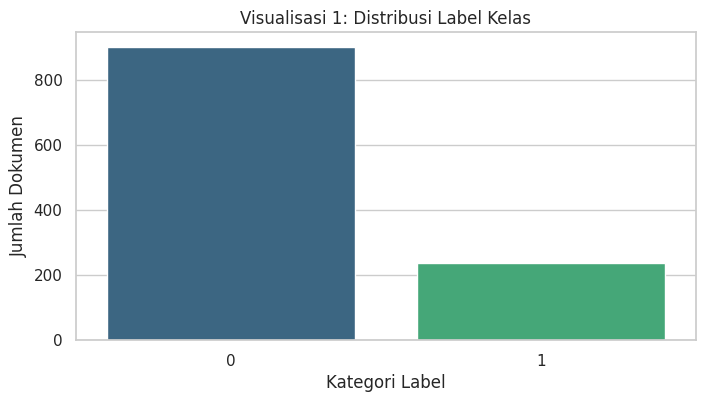

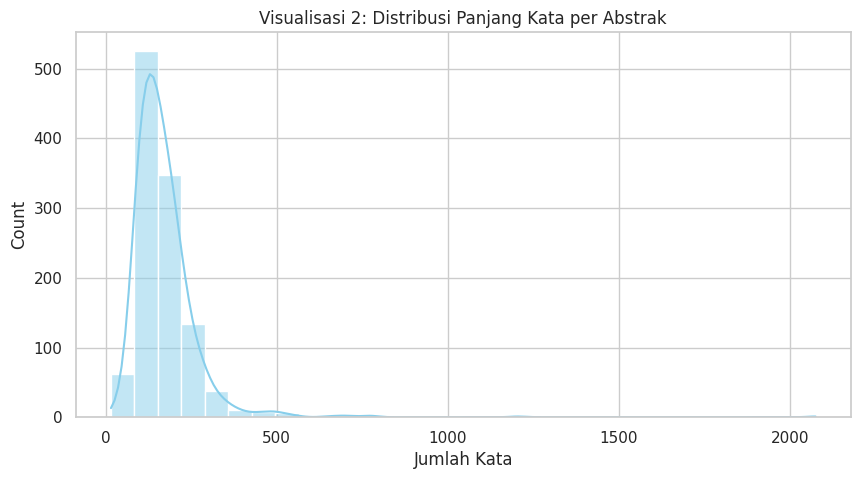

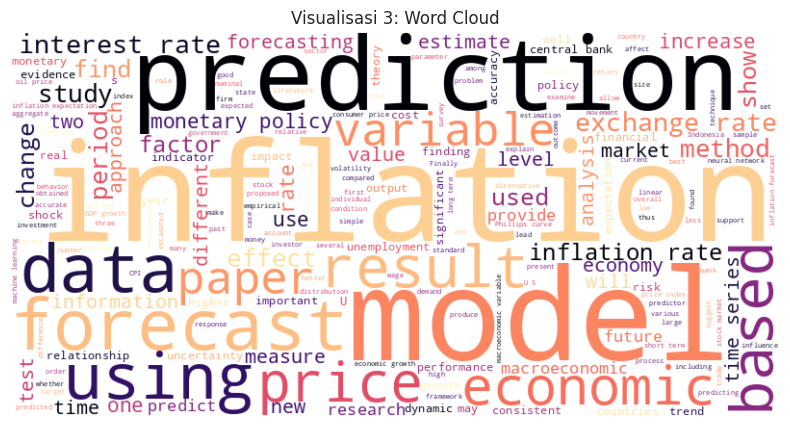

In [3]:
#@title Visualisasi Data (EDA)
print("--- Menampilkan Visualisasi ---")

# Visualisasi 1: Distribusi Label (Cek Imbalance)
plt.figure(figsize=(8, 4))
sns.countplot(x='Label', data=df, palette='viridis')
plt.title('Visualisasi 1: Distribusi Label Kelas')
plt.xlabel('Kategori Label')
plt.ylabel('Jumlah Dokumen')
plt.show()

# Feature Engineering Sederhana: Hitung jumlah kata
df['word_count'] = df['Abstract'].apply(lambda x: len(str(x).split()))

# Visualisasi 2: Distribusi Panjang Abstrak
plt.figure(figsize=(10, 5))
sns.histplot(df['word_count'], bins=30, kde=True, color='skyblue')
plt.title('Visualisasi 2: Distribusi Panjang Kata per Abstrak')
plt.xlabel('Jumlah Kata')
plt.show()

# Visualisasi 3: Word Cloud
text_combined = " ".join(t for t in df['Abstract'])
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(text_combined)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Visualisasi 3: Word Cloud')
plt.show()

In [4]:
#@title Preprocessing Data
print("--- Membersihkan Teks & Split Data ---")

stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()  # Huruf kecil
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Hapus angka/simbol
    text = ' '.join([w for w in text.split() if w not in stop_words])  # Hapus stopwords
    return text

# Terapkan cleaning
df['clean_abstract'] = df['Abstract'].apply(clean_text)

# Encoding Label (Mengubah Label Text -> Angka)
le = LabelEncoder()
df['label_enc'] = le.fit_transform(df['Label'])
num_classes = len(le.classes_)

# Split Data (80% Train, 20% Test)
X = df['clean_abstract']
y = df['label_enc']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"Data siap. Train size: {len(X_train)}, Test size: {len(X_test)}")

--- Membersihkan Teks & Split Data ---
Data siap. Train size: 910, Test size: 228


In [5]:
#@title Modeling ML Tradisional
print("--- Training Model Machine Learning ---")

# Vectorization (TF-IDF)
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train).toarray()
X_test_tfidf = tfidf.transform(X_test).toarray()

# Model 1: Naive Bayes (Baseline)
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
y_pred_nb = nb_model.predict(X_test_tfidf)
print("Model 1 (Naive Bayes) selesai dilatih.")

# Model 2: SVM
svm_model = SVC(kernel='linear', probability=True)
svm_model.fit(X_train_tfidf, y_train)
y_pred_svm = svm_model.predict(X_test_tfidf)
print("Model 2 (SVM) selesai dilatih.")

--- Training Model Machine Learning ---
Model 1 (Naive Bayes) selesai dilatih.
Model 2 (SVM) selesai dilatih.


In [6]:
#@title Modeling Deep Learning (LSTM)
print("--- Training Model Deep Learning (LSTM) ---")

# Parameter
MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200
EMBEDDING_DIM = 100

# Tokenization & Padding
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Arsitektur LSTM
model_dl = Sequential()
model_dl.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM))
model_dl.add(SpatialDropout1D(0.2))
model_dl.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_dl.add(Dense(num_classes, activation='softmax'))

model_dl.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Training
history = model_dl.fit(X_train_pad, y_train, epochs=5, batch_size=64, validation_split=0.1, verbose=1)

# Prediksi
y_pred_dl_prob = model_dl.predict(X_test_pad)
y_pred_dl = np.argmax(y_pred_dl_prob, axis=1)
print("Model 3 (LSTM) selesai dilatih.")

--- Training Model Deep Learning (LSTM) ---
Epoch 1/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 15s 442ms/step - accuracy: 0.7035 - loss: 0.6588 - val_accuracy: 0.8022 - val_loss: 0.4758
Epoch 2/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 491ms/step - accuracy: 0.7932 - loss: 0.4622 - val_accuracy: 0.8022 - val_loss: 0.4220
Epoch 3/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 9s 392ms/step - accuracy: 0.8322 - loss: 0.3372 - val_accuracy: 0.8681 - val_loss: 0.3513
Epoch 4/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 488ms/step - accuracy: 0.9346 - loss: 0.1809 - val_accuracy: 0.8571 - val_loss: 0.3692
Epoch 5/5
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 510ms/step - accuracy: 0.9653 - loss: 0.0979 - val_accuracy: 0.8571 - val_loss: 0.3884
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step
Model 3 (LSTM) selesai dilatih.



=== Evaluasi: Naive Bayes ===
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       180
           1       1.00      0.10      0.19        48

    accuracy                           0.81       228
   macro avg       0.90      0.55      0.54       228
weighted avg       0.85      0.81      0.74       228


=== Evaluasi: SVM ===
              precision    recall  f1-score   support

           0       0.93      0.99      0.96       180
           1       0.94      0.71      0.81        48

    accuracy                           0.93       228
   macro avg       0.94      0.85      0.88       228
weighted avg       0.93      0.93      0.93       228


=== Evaluasi: LSTM ===
              precision    recall  f1-score   support

           0       0.93      0.90      0.92       180
           1       0.67      0.75      0.71        48

    accuracy                           0.87       228
   macro avg       0.80      0.82      0.81       

/tmp/ipython-input-3644593498.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=models, y=accuracies, palette='rocket')


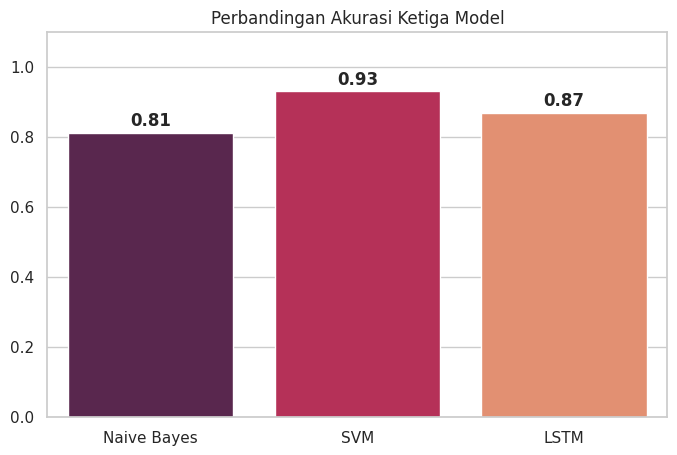

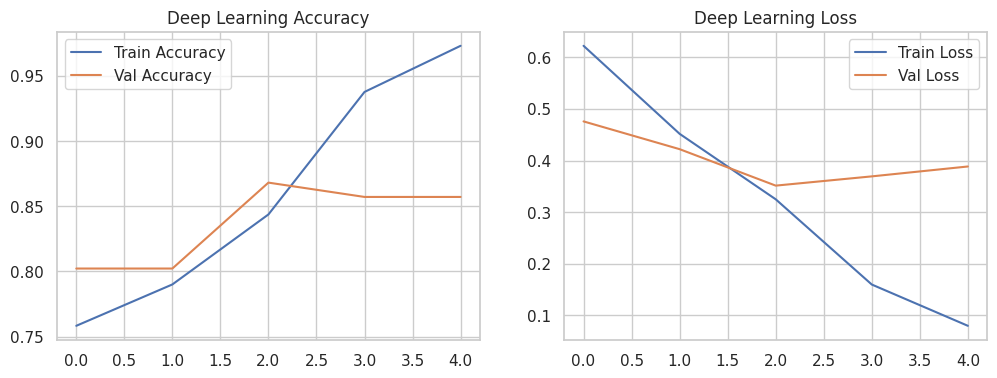

In [7]:
#@title Evaluasi Hasil
def evaluasi(nama_model, y_true, y_pred):
    print(f"\n=== Evaluasi: {nama_model} ===")
    print(classification_report(y_true, y_pred, target_names=le.classes_.astype(str)))
    return accuracy_score(y_true, y_pred)

acc_nb = evaluasi("Naive Bayes", y_test, y_pred_nb)
acc_svm = evaluasi("SVM", y_test, y_pred_svm)
acc_dl = evaluasi("LSTM", y_test, y_pred_dl)

# Grafik Perbandingan Akurasi
models = ['Naive Bayes', 'SVM', 'LSTM']
accuracies = [acc_nb, acc_svm, acc_dl]

plt.figure(figsize=(8, 5))
barplot = sns.barplot(x=models, y=accuracies, palette='rocket')
plt.title('Perbandingan Akurasi Ketiga Model')
plt.ylim(0, 1.1)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

# Grafik Training History LSTM
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Deep Learning Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Deep Learning Loss')
plt.legend()
plt.show()

In [8]:
#@title Menyimpan Model (Saving)
print("--- Menyimpan Model ke Folder 'models/' ---")

# Buat folder
if not os.path.exists('models'):
    os.makedirs('models')

# Simpan Model ML & Komponennya
joblib.dump(nb_model, 'models/model_baseline_nb.pkl')
joblib.dump(svm_model, 'models/model_svm.pkl')
joblib.dump(tfidf, 'models/tfidf_vectorizer.pkl')
joblib.dump(le, 'models/label_encoder.pkl')

# Simpan Model DL & Tokenizernya
model_dl.save('models/model_dl_lstm.h5')
joblib.dump(tokenizer, 'models/dl_tokenizer.pkl')

print("Semua model sukses disimpan!")
print("Cek folder 'models' di panel file sebelah kiri, lalu download isinya.")

--- Menyimpan Model ke Folder 'models/' ---
Semua model sukses disimpan!
Cek folder 'models' di panel file sebelah kiri, lalu download isinya.


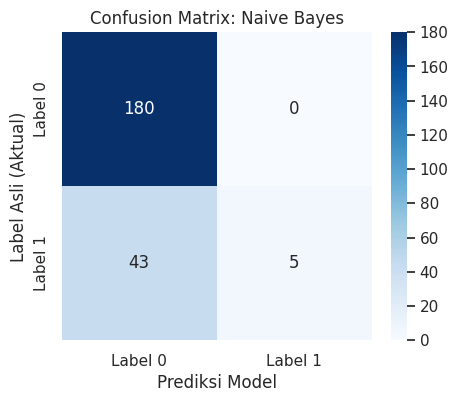

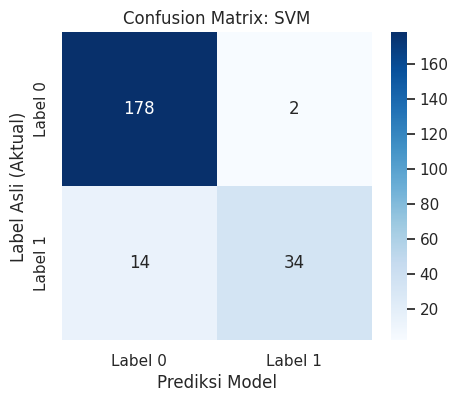

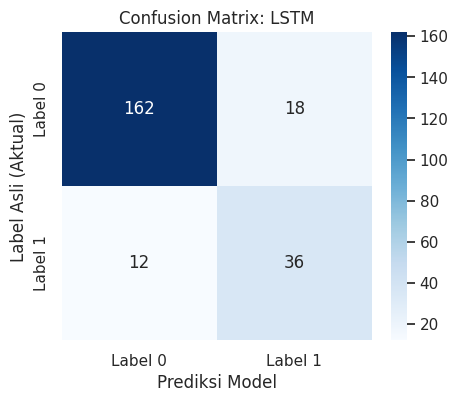

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Fungsi template agar kode lebih rapi
def plot_cm(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Label 0', 'Label 1'],
                yticklabels=['Label 0', 'Label 1'])
    plt.title(title)
    plt.xlabel('Prediksi Model')
    plt.ylabel('Label Asli (Aktual)')
    plt.show()

# 1. Tampilkan CM untuk Naive Bayes
plot_cm(y_test, y_pred_nb, 'Confusion Matrix: Naive Bayes')

# 2. Tampilkan CM untuk SVM
plot_cm(y_test, y_pred_svm, 'Confusion Matrix: SVM')

# 3. Tampilkan CM untuk LSTM
plot_cm(y_test, y_pred_dl, 'Confusion Matrix: LSTM')